<a href="https://colab.research.google.com/github/giuliovv/ball_beam/blob/master/nmpc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
colab = False

if colab:
  %pip install casadi

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *

In [19]:
# Hyperparameters
test_results = True
N = 10 # Number of control intervals
Q, R = 1e2, 1

Ts = 0.5 #T/N

Initialize states, inputs, and system dynamic equation

In [20]:
# States
x1 = MX.sym('x1')
x2 = MX.sym('x2')
x = vertcat(x1,x2) # Always vertically concatenate the states --> [n_x,1]
# Inputs
u1 = MX.sym('u')
u = vertcat(u1) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
f1 = 0.26*u1
f2 = x1
ode = vertcat(f1,f2) # ORDINARY DIFFERENTIAL EQUATION: Always vertically concatenate dynamic equations --> [n_x,1]
f = Function('f_o',[x,u],[ode],['x','u'],['ode'])
if test_results:
    print(f([0.2, 0.8], 0.1))

[0.026, 0.2]


Define the integrator to discretize the system

In [21]:
# Integrator to discretize the ordinary differential equation --> differential algebraic equation
intg_options = dict()
intg_options['tf'] = Ts
intg_options['simplify'] = True
intg_options['number_of_finite_elements'] = 4
# DAE problem structure
dae = dict()
dae['x'] = x    # Variables 
dae['p'] = u    # Parameters (N.B. for an MPC, the inputs are passed to DAE as parameters)
dae['ode'] = f(x,u) # Expression in continuos time

intg = integrator('intg','rk', dae, intg_options) # Runge-Kutta

if test_results: # To numerically evaluate the DAE
    res = intg(x0=[0,1],p=0)
    print(res['xf'])

# For the system dynamics, we need the symbolic DAE to update system state
res = intg(x0=x, p=u) 
x_next = res['xf'] # Access x_next as the DAE symbolic solution

# Define function F to simplify mapping between symbolic (x,u) --> (x_next)
F = Function('F',[x,u],[x_next],['x','u'],['x_next'])

[0, 1]


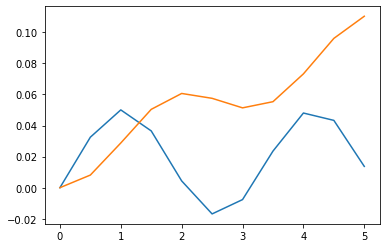

In [22]:
# Test the problem definition
sim = F.mapaccum(N) # To call the F function N times
x0 = [0,0]
res = sim(x0, np.cos(np.arange(N))/4) # Example: u1 = cosine excitation
fig = plt.figure()
tgrid = np.linspace(0,Ts*N,N+1)
plt.plot(tgrid, np.column_stack((x0, res)).T)

-------------------------------------------
This is casadi::QRQP
Number of variables:                              32
Number of constraints:                            42
Number of nonzeros in H:                          21
Number of nonzeros in A:                          92
Number of nonzeros in KKT:                       258
Number of nonzeros in QR(V):                     195
Number of nonzeros in QR(R):                     363
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0         0    -1        40     1    0.0024    33         0  
    1     0       -35      0.35    52     2e-13     5    0.0012    33         1  Added ubz to reduce |pr|, i=52
    2     0       -34     1e-15    34   5.7e-14     5    0.0012    33         1  Converged
MESSAGE(sqpmethod): Convergence achieved after 1 iterations


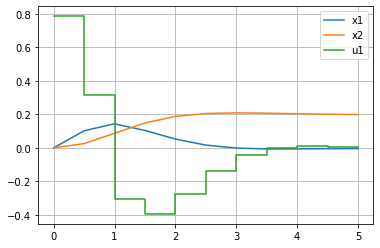

In [23]:
opti = Opti() # Special CasADi stack for optimization

x = opti.variable(2,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(1,N)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
p = opti.parameter(2,1)     # Parameter to set the initial state conditions (x(0))
r = opti.parameter(1)

obj = Q*sumsqr(x[1,:] - r) +R*sumsqr(u)# + 1e6*sumsqr(x[1,-1] - r)   # Objective function: (NOT NECESSARILY quadratic!)

opti.minimize(obj)          # Setup the problem 

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
    opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k])) # System dynamics is called through F, that we defined above as the DAE that maps (x,u) --> (x,next)
    
# 2) Additional states/inputs constraints 
opti.subject_to(u<=pi/4)        
opti.subject_to(u>=-pi/4)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0]==p)

opti.set_value(p,[0, 0]) # Set the initial x0 value
opti.set_value(r,0.2)

opts = dict()
opts["qpsol"] = "qrqp" # qrqp or osqp
opts["print_header"] = False
opts["print_iteration"] = False
opts["print_time"] = False
#opts["qpsol_options"] = dict({"print_iter":False,"print_header":False,"print_info":False})
opti.solver("sqpmethod", opts)

# If you want to test over 1 time horizon
if test_results:
    sol = opti.solve() # For testing purpose: test the optimization on 1 time step
    fig = plt.figure
    plt.plot(tgrid, sol.value(x[0,:]).T, label='x1')
    plt.plot(tgrid, sol.value(x[1,:]).T, label='x2')
    plt.plot(tgrid, np.column_stack((sol.value(u).reshape(1,-1), np.NaN)).T, drawstyle='steps-post', label='u1')
    plt.grid(True)
    plt.legend()

Final Step: run the MPC control loop!
N.B. Given that we want to simulate the system, e.g., 50 timesteps,
1. at each time step the previosly defined optimization problem computes inputs u and predicted states x in the prediction horizon N.
2. from computed sequence of inputs (u(0), ..., u(T)), ONLY u(0) value is selected to simulate the system
3. (x0, u(0)) --> x_next == x(1)
4. the loop restart

In [24]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('f',[p, r],[u[:,0]],['p', 'r'],['u_opt'])

-------------------------------------------
This is casadi::QRQP
Number of variables:                              32
Number of constraints:                            42
Number of nonzeros in H:                          21
Number of nonzeros in A:                          92
Number of nonzeros in KKT:                       258
Number of nonzeros in QR(V):                     195
Number of nonzeros in QR(R):                     363


In [25]:
# Reference point
r = 0.2

# MPC loop
X_log = np.empty((2,0))
U_log = np.array([])

x = [0,0]
for i in range(4*N):
    u = M(x, r)

    U_log = np.append(U_log, u)
    X_log = np.column_stack((X_log, x))

    # simulate
    x = F(x,u) #+ [0, np.random.rand()*0.02]

 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0         0    -1        40     1    0.0024    33         0  
    1     0       -35      0.35    52     2e-13     5    0.0012    33         1  Added ubz to reduce |pr|, i=52
    2     0       -34     1e-15    34   5.7e-14     5    0.0012    33         1  Converged
MESSAGE(sqpmethod): Convergence achieved after 1 iterations
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0       0.1    72        40     1    0.0024    33         0  
    1     0       -39   9.7e-16    34   1.7e-13     5    0.0024    33         1  Converged
MESSAGE(sqpmethod): Convergence achieved after 1 iterations
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0      0.14    72        40     1    0.0024    33         0  
    1     0       -42   1.2e-15    34   1.9e-13     5    0.0024    33         1  C

 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0       0.2    73        40     1    0.0024    33         0  
    1     0       -44   6.1e-17    49   1.2e-14     9    0.0024    33         1  Converged
MESSAGE(sqpmethod): Convergence achieved after 1 iterations
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0       0.2    73        40     1    0.0024    33         0  
    1     0       -44   5.9e-17    49   7.4e-15     7    0.0024    33         1  Converged
MESSAGE(sqpmethod): Convergence achieved after 1 iterations
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0       0.2    73        40     1    0.0024    33         0  
    1     0       -44     6e-17    48   1.1e-14     9    0.0024    33         1  Converged
MESSAGE(sqpmethod): Convergence achieved after 1 iterations
 Iter  Sing        fk      |pr|   con      

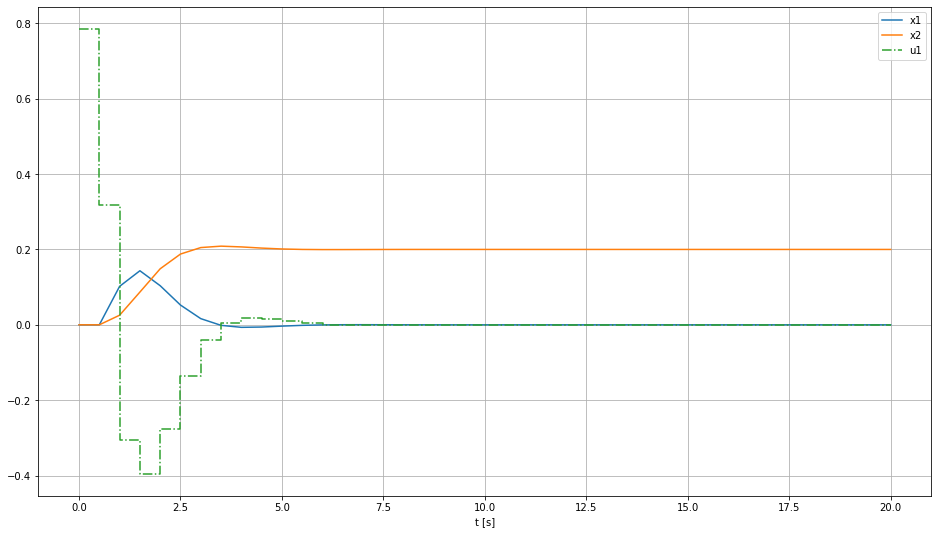

In [26]:
# Plot results!
fig = plt.figure(figsize=(16,9))
tgrid_mpc = np.linspace(0,4*Ts*N,4*N+1)
plt.plot(tgrid_mpc, np.append(x0[0], X_log[0,:]).T, label ='x1')
plt.plot(tgrid_mpc, np.append(x0[1], X_log[1,:]).T, label ='x2')
plt.plot(tgrid_mpc, np.append(U_log, np.NaN).T, linestyle='-.', drawstyle='steps-post', label="u1")
plt.xlabel('t [s]')
plt.grid(True)
plt.legend()

If you want to save the MPC controller, i.e. the M function for later use, you can do it!

In [27]:
M.save('M.casadi')
f = M

In [28]:
# Use this to build an S-Function

opts = dict(mex=True)
cg_options = dict()
cg_options["casadi_real"] = 'real_T'
cg_options["casadi_int"] = 'int_T'
cg_options["with_header"] = True
#cg_options["mex"] = True
cg = CodeGenerator('f',cg_options)
cg.add_include('simstruc.h');
cg.add(f);
cg.generate();

In [29]:
# Use this to build a simple MEX

#opts = dict(mex=True, with_header=True, casadi_real='real_T', casadi_int="int_T")
#f.generate('f.c',opts)

In [30]:
M([1, 1],0.1)

 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0         1    72        20     1    0.0024    33         0  
    1     0   3.2e+02        10    62       1.6     3    0.0012    33      0.92  Enforcing lbz, i=62
    2     0   5.7e+02        10    63      0.42     5   0.00073    33      0.74  Enforcing lbz, i=63
    3     0   9.3e+02        10    64      0.14     5   0.00048    33      0.67  Enforcing lbz, i=64
    4     0   1.4e+03        10    65     0.051    13   0.00034    33      0.63  Enforcing lbz, i=65
    5     0     2e+03        10    66      0.02     5   0.00025    33      0.61  Enforcing lbz, i=66
    6     0   2.7e+03        10    67    0.0079     9   0.00019    33       0.6  Enforcing lbz, i=67
    7     0   3.6e+03        10    68    0.0032     9   0.00015    33      0.59  Enforcing lbz, i=68
    8     0   4.4e+03        10    69    0.0014     9   0.00012    33      0.55  Enforcing lbz, i=69
    9     0   5.2e+03   

DM(-0.785398)